In [ ]:
#BUGIOLACCHI - 3.	Morphometric Data and Analytical Methods
#3.1.	Data Acquisition and Derivation
#Figure 3

# Mount Google Drive (run if not already mounted)
#from google.colab import drive
#drive.mount('/content/drive')

# 1. Read your profile DataFrames

import pandas as pd

df_we = pd.read_csv('/content/drive/MyDrive/.../cr_WE.csv')
df_ns = pd.read_csv('/content/drive/MyDrive/.../cr_NS.csv')

# 2. Instantiate and analyze
cp_we = CraterProfile(df_we, 'West–East')
metrics_we = cp_we.analyze()

cp_ns = CraterProfile(df_ns, 'North–South')
metrics_ns = cp_ns.analyze()

# 3. Plot and download figures
cp_we.plot(save=True)
cp_ns.plot(save=True)

# 4. Export individual CSV summaries
summary_we = cp_we.export()
summary_ns = cp_ns.export()

# 5. Combine summaries
summary_all = pd.concat([summary_ns, summary_we])

# 6. Clean up row labels: replace any mis-encoded or en-dash with a plain hyphen
summary_all.index = (
    summary_all.index
              .str.replace("â€“", "-", regex=False)  # fix mojibake
              .str.replace("–", "-", regex=False)   # replace real en-dash
)

# 7. Append a “Mean” row with the average of the two profiles
#    pandas will compute the mean for each numeric column
summary_all.loc["Mean"] = summary_all.mean(numeric_only=True)

# 8. (Optional) Re-order rows so Mean comes last
summary_all = summary_all.loc[["North-South", "West-East", "Mean"]]

# 9. Display & export
display(summary_all)
combined_filename = 'crater_summary_all.csv'
summary_all.to_csv(combined_filename)
print(f'Wrote {combined_filename}')

# 10. Trigger download in Colab
from google.colab import files
files.download(combined_filename)


In [ ]:
#BUGIOLACCHI - Sec 3. Morphometric Methods: Data Acquisition & Derivation
#Table 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
#from google.colab import files

class CraterProfile:
    """
    Analyze, visualize, and export metrics for a single crater cross-section.
    """

    def __init__(self, df: pd.DataFrame, label: str):
        """
        Parameters
        ----------
        df : pd.DataFrame
            Must contain columns 'Distance_km' and 'Elevation_m'.
        label : str
            Profile name, used for plot titles and filenames.
        """
        self.df = df.copy()
        self.label = label
        self.dist = df['Distance_km'].values
        self.elev = df['Elevation_m'].values

        # placeholders for intermediate results
        self.elev_s = None
        self.rim_idx = None
        self.left_bg_x = None
        self.right_bg_x = None
        self.left_bg_e = None
        self.right_bg_e = None

        # final metrics dictionary
        self.metrics = {}

    def analyze(self,
                smoothing_window: int = 11,
                polyorder: int = 3,
                prom_frac: float = 0.1,
                density: float = 2000):
        """
        Smooth the profile, detect rims, compute geometry & mass metrics.

        Returns
        -------
        metrics : dict
            Keys include:
            - Diameter_km
            - EdificeH1_m, EdificeH2_m, EdificeHMean_m
            - Angle1_deg, Angle2_deg, AngleMean_deg
            - CrossSectionVol_m3_per_m
            - Volume3D_m3
            - Mass_tonnes, Mass_Mt, Mass_Gt
        """
        # 1. Smooth elevation
        self.elev_s = savgol_filter(
            self.elev,
            window_length=smoothing_window,
            polyorder=polyorder
        )

        # 2. Detect rims by prominence
        prom_val = (self.elev_s.max() - self.elev_s.min()) * prom_frac
        peaks, props = find_peaks(self.elev_s, prominence=prom_val)
        rim_idx = peaks[np.argsort(props['prominences'])][-2:]
        rim_idx.sort()
        self.rim_idx = rim_idx

        rim_dists = self.dist[rim_idx]
        rim_elevs = self.elev_s[rim_idx]

        # 3. Define background points at ±1×D (clamped)
        D_km = rim_dists[1] - rim_dists[0]
        D_m  = D_km * 1000

        self.left_bg_x  = max(self.dist.min(),    rim_dists[0] - D_km)
        self.right_bg_x = min(self.dist.max(),    rim_dists[1] + D_km)
        self.left_bg_e  = np.interp(self.left_bg_x,  self.dist, self.elev_s)
        self.right_bg_e = np.interp(self.right_bg_x, self.dist, self.elev_s)

        # 4. Compute edifice heights & slope angles
        H1 = rim_elevs[0] - self.left_bg_e
        H2 = rim_elevs[1] - self.right_bg_e

        if D_m == 0:
            Angle1 = Angle2 = np.nan
        else:
            Angle1 = np.degrees(np.arctan(H1 / D_m))
            Angle2 = np.degrees(np.arctan(H2 / D_m))

        # 5. Cross-sectional volume per metre (area)
        mask = (np.arange(len(self.dist)) >= rim_idx[0]) & \
               (np.arange(len(self.dist)) <= rim_idx[1])
        x_m    = self.dist[mask] * 1000
        y_diff = np.mean(rim_elevs) - self.elev[mask]
        cs_vol = np.trapz(y_diff, x_m)

        # 6. Revolved 3D volume & mass
        V_3d     = cs_vol * (2 * np.pi * (D_m / 2))
        mass_kg  = V_3d * density
        mass_t   = mass_kg / 1e3
        mass_mt  = mass_t / 1e6
        mass_gt  = mass_t / 1e9

        # 7. Round and store metrics
        self.metrics = {
            'Diameter_km'           : round(D_km,   3),
            'EdificeH1_m'           : round(H1,      1),
            'EdificeH2_m'           : round(H2,      1),
            'Angle1_deg'            : round(Angle1,  1),
            'Angle2_deg'            : round(Angle2,  1),
            'EdificeHMean_m'        : round((H1+H2)/2, 1),
            'AngleMean_deg'         : round((Angle1+Angle2)/2, 1),
            'CrossSectionVol_m3_per_m': round(cs_vol,   2),
            'Volume3D_m3'           : round(V_3d,     0),
            'Mass_tonnes'           : round(mass_t,   0),
            'Mass_Mt'               : round(mass_mt,  3),
            'Mass_Gt'               : round(mass_gt,  3)
        }

        return self.metrics

    def plot(self, save: bool = False):
        """
        Plot raw vs. smoothed profile, annotate rims, background, heights, and
        slopes.

        Parameters
        ----------
        save : bool
            If True, saves 'profile_{label}.png' and triggers Colab download.

        Returns
        -------
        fig, ax : matplotlib objects
        """
        if not self.metrics:
            raise RuntimeError("Call analyze() before plot().")

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(self.dist, self.elev,   color='gray', alpha=0.4, label='Raw')
        ax.plot(self.dist, self.elev_s, color='C0',   lw=2,     label='Smoothed')

        # Mark rims and background
        rim_dists = self.dist[self.rim_idx]
        rim_elevs = self.elev_s[self.rim_idx]
        ax.scatter(rim_dists, rim_elevs, c='red', s=80, label='Rims')
        ax.scatter(
            [self.left_bg_x, self.right_bg_x],
            [self.left_bg_e, self.right_bg_e],
            c='C1', marker='x', s=80, label='Background ±1×D'
        )

        # Draw slope lines & annotate
        for i in [0, 1]:
            x0, y0 = (self.left_bg_x, self.left_bg_e) if i == 0 else (self.right_bg_x, self.right_bg_e)
            x1, y1 = rim_dists[i], rim_elevs[i]
            h   = self.metrics[f'EdificeH{i+1}_m']
            ang = self.metrics[f'Angle{i+1}_deg']
            ax.plot([x0, x1], [y0, y1], '--k', alpha=0.7)
            xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
            ax.annotate(
                f'{h:.1f} m\n{ang:.1f}°',
                xy=(xm, ym),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9
            )

        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Elevation (m)')
        ax.set_title(f'{self.label} Profile')
        ax.legend(loc='best')
        plt.tight_layout()

        if save:
            filename = f'profile_{self.label.replace(" ", "_")}.png'
            fig.savefig(filename, dpi=300)
            files.download(filename)

        return fig, ax

    def export(self, save_csv: bool = True):
        """
        Build a one-row summary DataFrame and optionally save to CSV.

        Returns
        -------
        summary : pd.DataFrame
        """
        if not self.metrics:
            raise RuntimeError("Call analyze() before export().")

        summary = pd.DataFrame([self.metrics], index=[self.label])
        if save_csv:
            filename = f'{self.label.replace(" ", "_")}_summary.csv'
            summary.to_csv(filename)
            print(f'Wrote {filename}')
        return summary

{'Timocharis': np.int32(3), 'Lambert': np.int32(3), 'Reiner': np.int32(3), 'Euler': np.int32(4), 'Delisle': np.int32(4), 'Le Verrier': np.int32(6), 'Pytheas': np.int32(5), 'Marius A': np.int32(1), 'Bessarion A': np.int32(2), 'Bancroft': np.int32(1)}


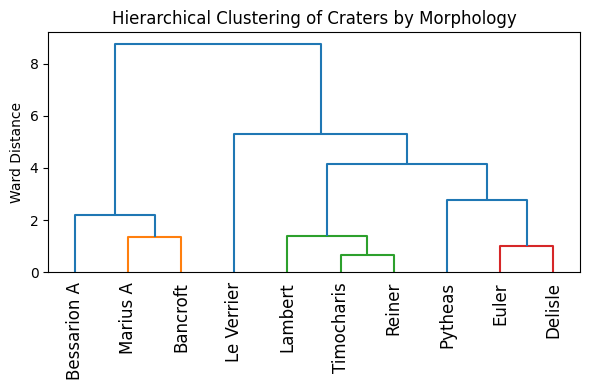

             Cluster
Crater              
Timocharis         3
Lambert            3
Reiner             3
Euler              4
Delisle            4
Le Verrier         6
Pytheas            5
Marius A           1
Bessarion A        2
Bancroft           1
   Cluster1  Cluster2  WardDist  Size
0       0.0       2.0  0.650600   2.0
1       3.0       4.0  1.025870   2.0
2       7.0       9.0  1.344867   2.0
3       1.0      10.0  1.391340   3.0
4       8.0      12.0  2.195853   3.0


In [ ]:
#BUGIOLACCHI - 3. Morphometric Data and Analytical Methods
#BUGIOLACCHI - 3.2.	Morphometric Clustering of Investigated Craters
#Figure 4.

import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Load your crater dataset
df_t = pd.read_csv("/content/drive/My Drive/.../crater_morphometry.csv", index_col=0)

params = [
    'Rim-crest Diameter_km',
    'Maximum Depth_km',
    'Floor Diameter_km',
    'Rampart Diameter_km',
    'Wall Slope angle_deg',
    'Rim to Rampart_km',
    'Rampart angle_deg'
]

# Normalize
data = df_t[params].astype(float)
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

# Distances + clustering
dist_condensed = pdist(data_norm, metric='euclidean')
Z = linkage(dist_condensed, method='ward')

# Flat clusters
cluster_ids = fcluster(Z, t=1.5, criterion='distance')
cluster_key = dict(zip(data.index, cluster_ids))
print(cluster_key)

# Plot dendrogram
plt.figure(figsize=(6,4))
dendrogram(Z, labels=data.index, leaf_rotation=90, color_threshold=1.5)
plt.title('Hierarchical Clustering of Craters by Morphology')
plt.ylabel('Ward Distance')
plt.tight_layout()
plt.show()

results = pd.DataFrame({
    'Crater': data.index,
    'Cluster': cluster_ids
}).set_index('Crater')

print(results)

Z_df = pd.DataFrame(Z, columns=['Cluster1','Cluster2','WardDist','Size'])
print(Z_df.head())

In [ ]:
#BUGIOLACCHI
#Figure 4 - Table Inset

# This snippet takes the hierarchical linkage matrix Z and builds a
# human-readable table showing each merge step, the two entities being joined
# (either original craters or previously formed clusters), the Ward distance at
# which they merge, and how many original craters are in the resulting cluster

import pandas as pd

# 1) Prepare Crater Names and Count
# crater_names holds the ordered list of your crater labels as they appear in
# the clustering data matrix n is used to distinguish “leaf” indices (0 to
# n–1) from internal cluster indices (n, n+1, …).
crater_names = list(data.index)    # e.g. ['Timocharis','Lambert',…,'Bancroft']
n = len(crater_names)              # should be 10

# 2) Build the Annotated Merge List
# enumerate(Z, start=1) loops through each of the n–1 merge operations in your
# linkage matrix
# The dictionary appended to annotated captures all relevant details for each
# merge step
annotated = []
for step, (c1, c2, dist, obs) in enumerate(Z, start=1):
    def label(idx):
        idx = int(idx)
        return crater_names[idx] if idx < n else f"cluster_{idx}"

    annotated.append({
        'merge_step':       step,
        'entity_1':         label(c1),
        'entity_2':         label(c2),
        'ward_distance':    round(dist, 3),
        'n_observations':   int(obs)
    })

# 3) Convert to a DataFrame
Z_annot = pd.DataFrame(annotated)

# 4) Display
print(Z_annot)

# Save the Annotated Merges to CSV
# index=False prevents pandas from writing the DataFrame’s index as a separate
# column
out_path = '/content/drive/My Drive/.../cluster_merges.csv'
Z_annot.to_csv(out_path, index=False)
print(f"✅ Written annotated merges to: {out_path}")

In [ ]:
#BUGIOLACCHI -  3.3.	High-Correlation Pair Identification Among Crater Metrics
#Table 2

import numpy as np
import pandas as pd

# 1) Compute the absolute correlation matrix
# Calculates the Pearson correlation coefficient between every pair of numeric
# columns in df_t, returning an n×n matrix.
# Converts all correlation values to their absolute magnitude, so you focus on
# strength regardless of positive or negative sign.
corr = df_t.corr().abs()

# 2) Mask Out the Lower Triangle and Diagonal
# Creates an n×n array of ones Keeps only the upper triangle above the diagonal
# (offset by k=1), zeros out the rest Converts ones/zeros into True/False mask
# Applies the mask so that only upper-triangle entries remain; everything else
# becomes NaN
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_masked = corr.where(mask)

# 3) Rename Axes for Clarity
corr_masked = corr_masked.rename_axis(index='Param1', columns='Param2')

# 4) Stack into a long DataFrame
# Converts the masked n×n matrix into a series of non-null pairs, each with a
# multi-index (Param1, Param2)
# Turns the multi-index into two regular columns (Param1 and Param2) and the
# correlation values into an AbsCorr column
corr_long = corr_masked.stack().reset_index(name='AbsCorr')

# 5) Filter for Strong Correlations and Sort
# Keeps only pairs whose absolute correlation exceeds 0.8
# Orders the pairs from strongest to weakest correlation
# Reindexes the rows 0, 1, 2… for a clean display
high_corr = (
    corr_long
    .loc[corr_long['AbsCorr'] > 0.8]
    .sort_values('AbsCorr', ascending=False)
    .reset_index(drop=True)
)

print("Pairs of parameters with |r| > 0.8:\n")
print(high_corr.to_string(index=False))

In [ ]:
#BUGIOLACCHI - 3.4. Scaling Relationships between Floor,
#Rampart and Rim-Crest Diameters
#Equations 1 and 2

# This code pulls the two most correlated crater metrics (rim‐crest diameter
# D and floor diameter F), filters out invalid entries, fits both a linear model
# and a power‐law model, evaluates each fit via R², tabulates the raw vs.
# predicted values and residuals, and finally plots the data with both fit
# curves

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# 0. Assume df is already loaded, transposed and cleaned:
# df.index = crater names, columns include 'Rim-crest Diameter_km' and 'Floor_Diameter_km'

# 1. Extract and mask valid data
# Converts both columns to numeric, coercing non-numeric entries to NaN
# Builds a boolean mask keeping only positive values for both D and F
# Filters D and F to only valid crater pairs
D = pd.to_numeric(df['Rim-crest Diameter_km'], errors='coerce')
F = pd.to_numeric(df['Floor Diameter_km'],   errors='coerce')
mask = (D > 0) & (F > 0)
D = D[mask]
F = F[mask]

# 2. Linear fit: F = m * D + c
# Uses np.polyfit of degree 1 to solve for slope m and intercept c
# Predicts floor diameters via F_lin_pred
# Computes the coefficient of determination R^2 with r2_score
m, c = np.polyfit(D, F, 1)
F_lin_pred = m * D + c
r2_lin = r2_score(F, F_lin_pred)

print(f'Linear fit: F = {m:.3f}·D + {c:.3f}   (R² = {r2_lin:.3f})')

# 3. Power-law fit: F = a * D^b
# Transforms to log–log space and fits a line to \log_{10}F = b\,\log_{10}D +
# \log_{10}a
# Recovers a by exponentiation
# Predicts via F_pow_pred and computes R² on the log–log relationship
logD = np.log10(D)
logF = np.log10(F)
b, log10a = np.polyfit(logD, logF, 1)
a = 10**log10a
F_pow_pred = a * D**b
r2_pow = r2_score(logF, logD * b + log10a)

print(f'Power-law fit: F = {a:.3f}·D^{b:.3f}   (log–log R² = {r2_pow:.3f})')

# 4. Assemble results table
# Builds a DataFrame with raw diameters, both predictions, and their residuals
# - Sorts by rim‐crest diameter for easier inspection
results = pd.DataFrame({
    'D (km)':          D,
    'F (km)':          F,
    'F_lin_pred (km)': F_lin_pred,
    'Res_lin (km)':    F - F_lin_pred,
    'F_pow_pred (km)': F_pow_pred,
    'Res_pow (km)':    F - F_pow_pred
})

results = results.sort_values('D (km)')
print(results)

# 5. Plot the Fits
# The first figure shows the linear regression on original axes
# The second uses log–log scaling to visualize and compare the power‐law
# behavior
import matplotlib.pyplot as plt

# Linear on linear axes
plt.figure(figsize=(6,5))
plt.scatter(D, F, label='Measured', alpha=0.6)
plt.plot(D, F_lin_pred, color='C1', label=f'Linear: F={m:.2f}D+{c:.2f}')
plt.xlabel('Rim-crest Diameter D (km)')
plt.ylabel('Floor Diameter F (km)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Power law on log-log axes
plt.figure(figsize=(6,5))
plt.loglog(D, F, 'o', alpha=0.6, label='Measured')
D_fit = np.logspace(np.log10(D.min()), np.log10(D.max()), 200)
plt.loglog(D_fit, a * D_fit**b, '-', color='C2',
           label=f'Power: F={a:.2f}·D^{b:.2f}')
plt.xlabel('Rim-crest Diameter D (km)')
plt.ylabel('Floor Diameter F (km)')
plt.legend()
plt.grid(which='both', ls=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#BUGIOLACCHI - 3.5. Comparative Power-Law Scaling of Rampart Extent
#Figure 5


# Environment Setup & I/O
# Defines an output_dir for all plots and ensures it exists before saving
# Using PdfPages import prepares for multi-page PDF exports later

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

from google.colab import drive
drive.mount('/content/drive')

# Switch working directory
target = "/content/drive/My Drive/.../DATA"
os.chdir(target)

# Create output folder
output_dir = "./CraterPlots"
os.makedirs(output_dir, exist_ok=True)

# 1. Define Raw Data & Morphology Label
# D and Dr hold rim‐crest and rampart diameters (km) for 10 craters
# morph_types tags each crater as “Simple” or “Complex” in the same order
# as the arrays
D  = np.array([32, 30, 26, 30, 15, 13, 20, 13, 21, 26])
Dr = np.array([76, 70, 59, 69, 36, 27, 41, 28, 45, 55])
morph_types = ['Complex','Complex','Simple','Complex','Simple',
               'Simple','Complex','Simple','Complex','Simple']

# 2. Overall Power-Law Fit & Confidence Band
# - Performs OLS regression on log₁₀(Dr) vs. log₁₀(D) to estimate prefactor a
# and exponent n
#Extracts 95% confidence intervals for the intercept and slope,
# then back-transforms to power-law bounds
#- Generates a finely spaced D_plot vector to draw smooth fit and
# CI curves on a log–log plot
logD, logDr = np.log10(D), np.log10(Dr)
overall_model = sm.OLS(logDr, sm.add_constant(logD)).fit()
icpt, slp = overall_model.params
a, n = 10**icpt, slp

ci = overall_model.conf_int()
a_low,  n_low  = 10**ci[0,0], ci[1,0]
a_high, n_high = 10**ci[0,1], ci[1,1]

# Smooth curve for plotting
D_plot = np.linspace(D.min()*0.8, D.max()*1.2, 200)
Dr_fit    = a      * D_plot**n
Dr_low    = a_low  * D_plot**n_low
Dr_high   = a_high * D_plot**n_high

# Summary Plot vs. Literature Scaling
# Overlays your best-fit scaling curve, its 95% CI, and two reference bands
# from the literature
# Uses log–log axes to linearize the power-law relationship
# - Saves a high-resolution PNG into CraterPlots for inclusion in
# manuscript figures
Dr_HH_low  = 1.0 * D_plot**1.0
Dr_HH_high = 1.5 * D_plot**1.0
Dr_P_low   = 0.8 * D_plot**0.85
Dr_P_high  = 1.2 * D_plot**0.95

# 3. Save overall summary plot
plt.figure(figsize=(8,6))
plt.scatter(D, Dr, s=50, c='k', label='Your data')
plt.plot(D_plot, Dr_fit,   c='b', lw=2, label=f'Fit: {a:.2f}·D^{n:.2f}')
plt.fill_between(D_plot, Dr_low, Dr_high, color='b', alpha=0.2,
                 label='95% CI')
plt.fill_between(D_plot, Dr_HH_low, Dr_HH_high, color='green', alpha=0.2,
                 label='H&H (2011): a=1.0–1.5, n=1.0')
plt.fill_between(D_plot, Dr_P_low, Dr_P_high, color='orange', alpha=0.2,
                 label='Pike (1974): a=0.8–1.2, n=0.85–0.95')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Crater Diameter D (km)')
plt.ylabel('Rampart Diameter Dr (km)')
plt.title('Power‐Law Scaling: Your Fit vs. Literature')

# Legend with white background
leg = plt.legend(loc='lower right', fontsize='small', frameon=True)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(1.0)

plt.grid(which='both', ls='--', lw=0.5)
plt.tight_layout()

summary_png = os.path.join(output_dir, "fit_summary_plot.png")
plt.savefig(summary_png, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ Saved overall summary to {summary_png}")

# 4. Morphology-Specific Fits & Residuals PD
# Constructs a DataFrame grouping craters by Morph
# For each morphology, repeats the log-OLS fit, computes per-group CI bands,
# and calculates residuals in log-space
# Left panel shows the morphological subset’s fit against the same literature
# bands
# Right panel visualizes deviations from the fit, aiding morphological bias
# interpretation
# Saves all pages in a single PDF using PdfPages for seamless SI distribution

df = pd.DataFrame({'D': D, 'Dr': Dr, 'Morph': morph_types})
pdf_path = os.path.join(output_dir, "Morphology_with_Residuals_and_CI.pdf")

with PdfPages(pdf_path) as pdf:
    for morph, group in df.groupby('Morph'):
        x = group['D'].values
        y = group['Dr'].values
        logx, logy = np.log10(x), np.log10(y)

        # Fit per morphology
        mod = sm.OLS(logy, sm.add_constant(logx)).fit()
        icpt_m, slp_m = mod.params
        a_m = 10**icpt_m

        # CIs for per‐morph model
        ci_m = mod.conf_int()
        a_m_low,  n_m_low  = 10**ci_m[0,0], ci_m[1,0]
        a_m_high, n_m_high = 10**ci_m[0,1], ci_m[1,1]

        # Smooth curve for this subset
        Dp = np.linspace(x.min()*0.8, x.max()*1.2, 200)
        Dr_m_fit    = a_m       * Dp**slp_m
        Dr_m_low    = a_m_low   * Dp**n_m_low
        Dr_m_high   = a_m_high  * Dp**n_m_high

        # Compute residuals
        logy_pred = icpt_m + slp_m*logx
        resid = logy - logy_pred

        # Build figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

        # Left: fit + CIs + literature (with labels)
        ax1.scatter(x, y, s=60, c='tab:blue')
        ax1.plot(Dp, Dr_m_fit, lw=2, c='tab:blue',
                 label=f'Fit: {a_m:.2f}·D^{slp_m:.2f}')
        ax1.fill_between(Dp, Dr_m_low, Dr_m_high, color='tab:blue', alpha=0.2,
                         label='95% CI')
        ax1.fill_between(Dp, Dr_HH_low, Dr_HH_high, color='green', alpha=0.2,
                         label='H&H (2011): a=1.0–1.5, n=1.0')
        ax1.fill_between(Dp, Dr_P_low, Dr_P_high, color='orange', alpha=0.2,
                         label='Pike (1974): a=0.8–1.2, n=0.85–0.95')

        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('D (km)')
        ax1.set_ylabel('Dr (km)')
        ax1.set_title(f'{morph} Craters: Fit & CI')

        # Legend with white background
        leg1 = ax1.legend(frameon=True, fontsize='small')
        leg1.get_frame().set_facecolor('white')
        leg1.get_frame().set_alpha(1.0)

        ax1.grid(which='both', ls='--', lw=0.5)

        # Right: residuals
        ax2.scatter(logx, resid, s=60, c='tab:red')
        ax2.hlines(0, logx.min()*1.05, logx.max()*1.05,
                   colors='gray', linestyles='--', lw=1)
        ax2.set_xlabel('log10(D)')
        ax2.set_ylabel('Residual = log10(Dr) – fit')
        ax2.set_title(f'{morph} Residuals')
        ax2.grid(which='both', ls='--', lw=0.5)

        plt.suptitle(f'{morph} Craters', y=1.02)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"✅ Saved morphology-split pages to {pdf_path}")

In [ ]:
#BUGIOLACCHI - 4.	Morphological Maturity Index (MMI): A Quantitative Framework for
#Crater Degradation
#Table 3

import pandas as pd
import io
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Data ---
table_str = """
SUMMARY	Timocharis	Lambert	Reiner	Euler	Delisle	Le Verrier	Pytheas	Marius A	Bessarion A	Bancroft
Rim-crest Diameter_km	32	30	30	26	26	21	18	15	13	13
Maximum Depth_km	2.991	2.655	2.925	2.386	2.617	1.976	2.575	2.772	2.228	2.560
Floor Diameter_km	15	15	14	13	12	9	7	6	5	4
Rampart Diameter_km	76	70	69	59	55	45	41	36	27	27
Wall Slope angle_deg	10.6	9.9	10.6	10.2	11.4	10.7	13.9	19.5	19.2	20.5
Rim to Rampart_km	0.873	0.804	0.859	0.834	0.772	0.443	0.791	0.691	0.503	0.575
Rampart angle_deg	1.6	1.5	1.7	1.9	1.8	1.3	2.3	2.6	2.3	2.6
"""

# --- Base DF with core metrics ---
df = pd.read_csv(io.StringIO(table_str), sep="\t", index_col=0).T.apply(pd.to_numeric, errors="coerce")
df["depth_ratio"]   = df["Maximum Depth_km"] / df["Rim-crest Diameter_km"]
df["wall_slope"]    = df["Wall Slope angle_deg"]
df["rampart_angle"] = df["Rampart angle_deg"]
df["rim_relief"]    = df["Rim to Rampart_km"]

def normalise(s): return (s - s.min()) / (s.max() - s.min())
df["norm_depth"]          = normalise(df["depth_ratio"])
df["norm_wall_slope"]     = normalise(df["wall_slope"])
df["norm_rampart_angle"]  = normalise(df["rampart_angle"])
df["norm_rim_relief"]     = normalise(df["rim_relief"])

def compute_scheme(df_in, tag, w_depth, w_wall, w_ramp, w_rim):
    d = df_in.copy()
    d[f"MMI_balanced_raw_{tag}"] = (
        w_depth * d["norm_depth"] +
        w_wall * d["norm_wall_slope"] +
        w_ramp * d["norm_rampart_angle"] +
        w_rim * d["norm_rim_relief"]
    )
    d[f"MMI_scr_{tag}"] = d[f"MMI_balanced_raw_{tag}"] * 10 + 8
    d[f"MMI_0-1_{tag}"] = MinMaxScaler().fit_transform(d[[f"MMI_scr_{tag}"]])
    d[f"MMI_z_{tag}"]   = StandardScaler().fit_transform(d[[f"MMI_scr_{tag}"]])
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    d[f"cluster_raw_{tag}"] = kmeans.fit_predict(d[[f"MMI_scr_{tag}"]])
    means = d.groupby(f"cluster_raw_{tag}")[f"MMI_scr_{tag}"].mean().sort_values()
    remap = {old: new for new, old in enumerate(means.index)}
    d[f"cluster_{tag}"] = d[f"cluster_raw_{tag}"].map(remap)
    names = {0:"Degraded", 1:"Mid-Degraded", 2:"Fresh"}
    d[f"cluster_name_{tag}"] = d[f"cluster_{tag}"].map(names)
    d[f"silhouette_{tag}"]   = silhouette_samples(d[[f"MMI_scr_{tag}"]], d[f"cluster_{tag}"])
    return d

# --- Compute both schemes (S1 and S2) ---
df_s1 = compute_scheme(df, "S1", 0.45, 0.30, 0.15, 0.10)
df_s2 = compute_scheme(df, "S2", 0.50, 0.25, 0.15, 0.10)

# --- Build the two-block output ONLY ---
df_out = pd.concat(
    [
        df_s1[["MMI_scr_S1", "MMI_0-1_S1", "MMI_z_S1", "cluster_name_S1", "silhouette_S1"]],
        df_s2[["MMI_scr_S2", "MMI_0-1_S2", "MMI_z_S2", "cluster_name_S2", "silhouette_S2"]],
    ],
    axis=1
)

# --- Sanity check: print final columns ---
print("Final columns:", list(df_out.columns))

In [ ]:
#BUGIOLACCHI - 5. Geochemical and Thermal Slope Analysis of Lunar Craters
#Slopes Derivation

#Import and mount Google Drive
#importing the two files with Multispectral and Morphology datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Then point to your files, e.g.:
ms_path    = '/content/drive/MyDrive/.../MORPH1.csv'
morph_path = '/content/drive/MyDrive/.../subset.csv'

# Import Pandas and Load the Tables

import pandas as pd

# Load files
ms_df    = pd.read_csv(ms_path)
morph_df = pd.read_csv(morph_path)

# Merge Multispectral and Morphology Tables
# Performs a left join of ms_df with morph_df using the crater column as the key
combined_df = ms_df.merge(morph_df, on='crater', how='left')
combined_df.info()
combined_df.head()

# Defining and Applying an Ordinal mapping for Zone Labels
# Create a dictionary zone_order that explicitly assigns each textual zone
# label an integer rank (Floor → 0, Wall → 1, etc.)
# Calling morph_df['zone'].map(zone_order) looks up each crater’s zone value
# in that dictionary and returns the corresponding integer

zone_order = {
    'Floor':       0,
    'Wall':        1,
    'Rampart':     2,
    'Background':  3
}
morph_df['zone_idx'] = morph_df['zone'].map(zone_order)

#Function to Estimate a Linear Trend Across Crater Zones

import numpy as np
import pandas as pd

# Taken together, series and x define paired observations:
# series might be a vector of mineral abundances or geochemical values
# measured in each morphological zone (floor, wall, rampart, background)
# x is the corresponding zone_idx (0–3) that orders these zones from
# crater floor outward.
# Internally, np.polyfit(x, series, 1) fits a straight line
# \text{series} \approx \text{slope}\times x + \text{intercept}
# By returning only slope, the function quantifies the rate of change of
# the measured quantity across zones
def fit_slope(series, x):
    # series: values (e.g. wt% of Olivine), x: zone_idx
    slope, intercept = np.polyfit(x, series, 1)
    return slope

    # Define Geochemical Variables
# Keeps the loop generic—add or remove variables here rather than editing
# the loop itself.
geo_vars = ['Olivine','FeO','TiO2','CPX','OPX','Plag','T_An']

# Prepare a Results Container
crater_slopes = []

# Loop Over Craters & Compute Slopes
# Grouping: morph_df.groupby('crater') splits your table into
# sub-DataFrames, one per crater.
# Zone index x: numerical array [0–3] ordering zones from floor to background
# Inner loop: for each geochemical variable extracts the zonal concentrations y'
# Calls fit_slope(y, x), which returns the linear coefficient quantifying
# the gradient across zones
# Stores that slope in the slopes dict under a descriptive key (e.g. 'FeO_slope')
for crater, df in morph_df.groupby('crater'):
    x = df['zone_idx'].values
    slopes = {'crater': crater}
    for var in geo_vars:
        y = df[var].values
        slopes[f'{var}_slope'] = fit_slope(y, x)
    crater_slopes.append(slopes)

# Build the Final Slopes DataFrame
slopes_df = pd.DataFrame(crater_slopes)

# Export the slopes DataFrame to CSV
slopes_df.to_csv('crater_geochem_slopes.csv', index=False)

# Trigger a browser download in Colab
from google.colab import files
files.download('crater_geochem_slopes.csv')

# Gather all Slope Variables

# 1. Identify slope columns
slope_cols = [c for c in slopes_df.columns if c.endswith('_slope')]

# 2. Standardize Each Slope Series
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_slopes = scaler.fit_transform(slopes_df[slope_cols])

# 3. Confirm the Resulting Array Shap
print(scaled_slopes.shape)   # should be (n_craters, n_slopes)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/.../MORPH1.csv'

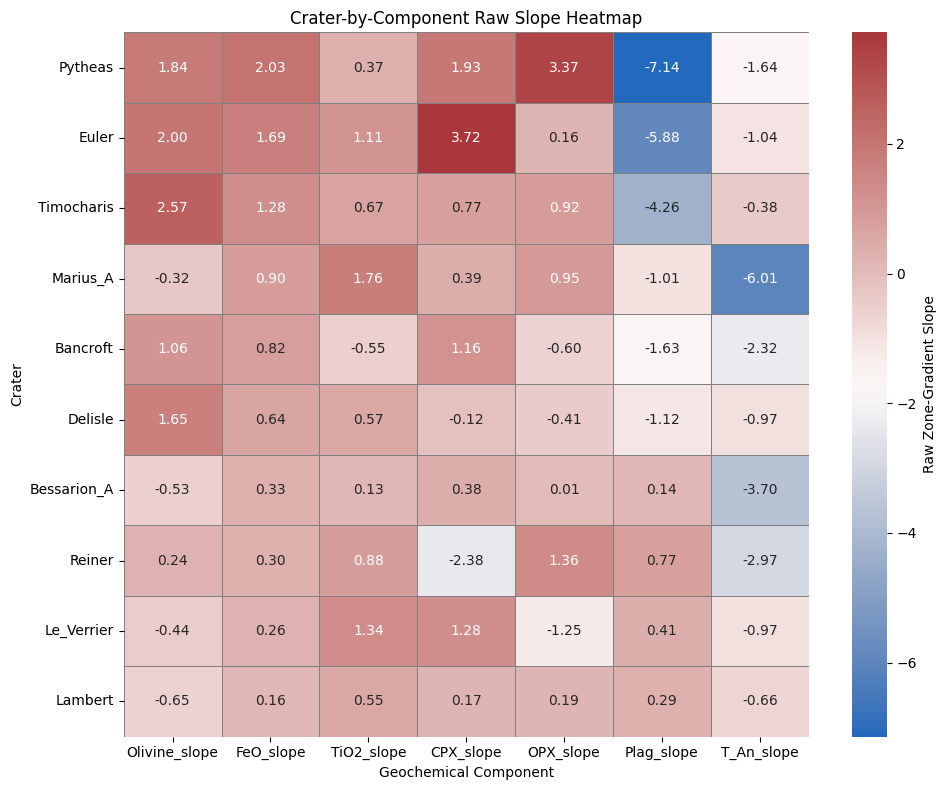

In [ ]:
#BUGIOLACCHI - 5.1.	Derivation of Radial Geochemical Slopes
#Figure 7

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the CSV you originally exported
slopes_df = pd.read_csv('crater_geochem_slopes.csv')

# 2. Pick out only the slope columns
slope_cols = [c for c in slopes_df.columns if c.endswith('_slope')]

# 3. Reindex by crater so rows are named
heatmap_df = slopes_df.set_index('crater')[slope_cols]

# Example: sort craters by descending Olivine_slope
heatmap_df = heatmap_df.sort_values('FeO_slope', ascending=False)

# 4. Plot the heatmap of raw slopes
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_df,
    cmap='vlag',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Raw Zone-Gradient Slope'},
    xticklabels=True,
    yticklabels=True
)
plt.title('Crater-by-Component Raw Slope Heatmap')
plt.xlabel('Geochemical Component')
plt.ylabel('Crater')
plt.tight_layout()
plt.show()

Mounted at /content/drive
Rows (craters): 10
Features used: 9 -> ['Olivine_slope', 'FeO_slope', 'TiO2_slope', 'CPX_slope', 'OPX_slope']...
Feature matrix shape: (10, 9)
Linkage matrix shape: (9, 4)


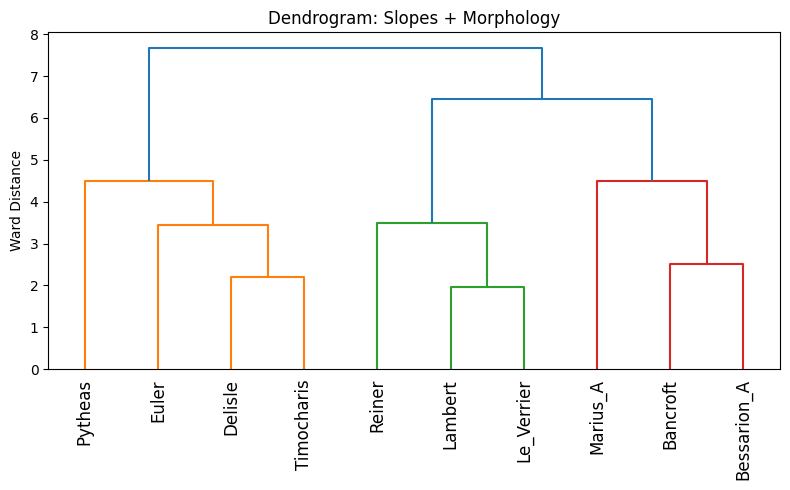

Saved merge history to: /content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/ward_merge_history.csv
Saved linkage matrix to: /content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/dendrogram_linkage.csv
Saved cluster assignments to: /content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/crater_clusters.csv
/content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/ward_merge_history.csv exists? True
/content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/dendrogram_linkage.csv exists? True
/content/drive/MyDrive/SCIENCE/PROJECTS/Proj_16_Chain_Craters/DATA/crater_clusters.csv exists? True


In [ ]:
#BUGIOLACCHI - 6.	Integrated Morphometric–Geochemical Analysis
#6.1.	Integration of Radial-Slope Features with Key Morphometric Descriptors
#Figure 8

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
base_path = "/content/drive/MyDrive/.../DATA"
os.makedirs(base_path, exist_ok=True)  # ensure directory exists

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
slopes_df  = pd.read_csv(os.path.join(base_path, "crater_geochem_slopes.csv"))
metrics_df = pd.read_csv(os.path.join(base_path, "MORPH1.csv"))

# Merge on crater name
df = pd.merge(slopes_df, metrics_df, on='crater', how='inner')
assert 'crater' in df.columns, "No 'crater' column after merge."

# -------------------------------------------------------------------
# 2. Select features
# -------------------------------------------------------------------
slope_cols = [c for c in df.columns if c.endswith('_slope')]
morph_cols = ['d_D', 'MMI_0_1']  # adjust if needed

missing = [c for c in morph_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing morph columns: {missing}")

all_features = slope_cols + morph_cols
if not all_features:
    raise ValueError("No features selected: check *_slope columns and morph_cols.")

# Standardise
scaler = StandardScaler()
X = scaler.fit_transform(df[all_features])

print(f"Rows (craters): {df.shape[0]}")
print(f"Features used: {len(all_features)} -> {all_features[:5]}{'...' if len(all_features)>5 else ''}")
print(f"Feature matrix shape: {X.shape}")

# -------------------------------------------------------------------
# 3. Ward hierarchical clustering
# -------------------------------------------------------------------
Z = linkage(X, method='ward')
print(f"Linkage matrix shape: {Z.shape}")  # should be (n_craters-1, 4)

plt.figure(figsize=(8, 5))
dendrogram(
    Z,
    labels=df['crater'].tolist(),
    leaf_rotation=90,
    color_threshold=0.6 * float(np.max(Z[:, 2]))
)
plt.title('Dendrogram: Slopes + Morphology')
plt.ylabel('Ward Distance')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 4. Merge-history table with full names
# -------------------------------------------------------------------
def ward_merge_table_fullnames(Z, labels):
    """
    Build merge-history table with full crater names for both entities.
    Columns: Merge_Step, Entity_1, Entity_2, Ward_distance, n_observations
    """
    n = len(labels)
    # map current cluster index -> list of names
    contents = {i: [labels[i]] for i in range(n)}
    rows = []
    for step, (c1, c2, dist, n_obs) in enumerate(Z, start=1):
        c1, c2 = int(c1), int(c2)
        names1 = contents[c1]
        names2 = contents[c2]
        rows.append({
            "Merge_Step": step,
            "Entity_1": ", ".join(names1),
            "Entity_2": ", ".join(names2),
            "Ward_distance": float(dist),
            "n_observations": int(n_obs)
        })
        contents[n + step - 1] = names1 + names2
    return pd.DataFrame(rows)

labels = df['crater'].tolist()
merge_df = ward_merge_table_fullnames(Z, labels)

merge_out = os.path.join(base_path, "ward_merge_history.csv")
merge_df.to_csv(merge_out, index=False)
print("Saved merge history to:", merge_out)

# -------------------------------------------------------------------
# 5. Save linkage and flat clusters
# -------------------------------------------------------------------
linkage_out = os.path.join(base_path, "dendrogram_linkage.csv")
pd.DataFrame(Z, columns=["cluster1", "cluster2", "distance", "n_obs"]).to_csv(linkage_out, index=False)

df['cluster'] = fcluster(Z, t=4, criterion='maxclust')
clusters_out = os.path.join(base_path, "crater_clusters.csv")
df[['crater', 'cluster']].to_csv(clusters_out, index=False)

print("Saved linkage matrix to:", linkage_out)
print("Saved cluster assignments to:", clusters_out)

# -------------------------------------------------------------------
# 6. Verify files exist
# -------------------------------------------------------------------
for p in [merge_out, linkage_out, clusters_out]:
    print(p, "exists?", os.path.exists(p))


                      D       d_D   MMI_0_1  Olivine_slope  FeO_slope  \
D              1.000000 -0.884121 -0.727008       0.287474  -0.140679   
d_D           -0.884121  1.000000  0.866250      -0.242311   0.105623   
MMI_0_1       -0.727008  0.866250  1.000000       0.048632   0.376901   
Olivine_slope  0.287474 -0.242311  0.048632       1.000000   0.818182   
FeO_slope     -0.140679  0.105623  0.376901       0.818182   1.000000   
TiO2_slope     0.330289 -0.304442 -0.419455       0.054545  -0.006061   
CPX_slope     -0.281357  0.006213 -0.066870       0.430303   0.612121   
OPX_slope      0.305823 -0.093196  0.115502       0.236364   0.393939   
Plag_slope     0.116213  0.006213 -0.279637      -0.781818  -0.915152   
T_An_slope     0.703394 -0.776637 -0.711249       0.296970  -0.090909   

               TiO2_slope  CPX_slope  OPX_slope  Plag_slope  T_An_slope  
D                0.330289  -0.281357   0.305823    0.116213    0.703394  
d_D             -0.304442   0.006213  -0.093196 

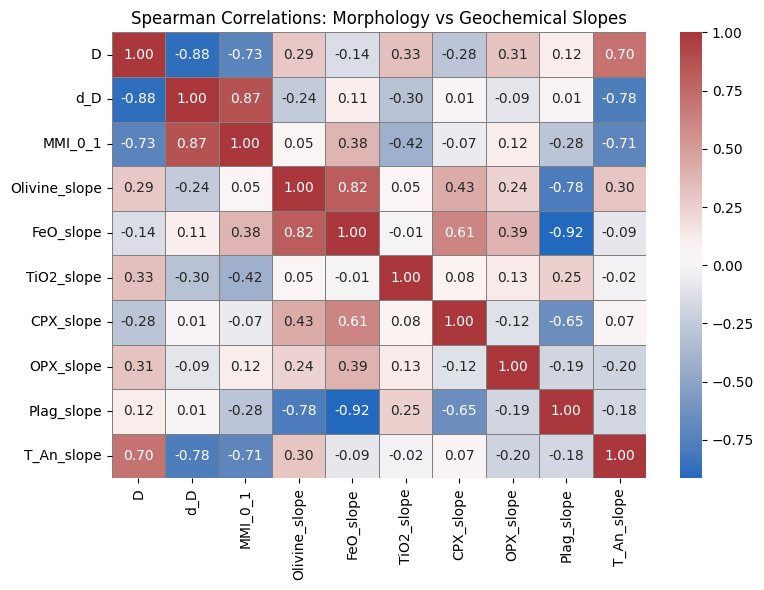

In [ ]:
#BUGIOLACCHI - 6.2.	Spearman Correlations between Morphology and Geochemical Slopes
#Figure 9

import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
features = ["D","d_D", "MMI_0_1"]  # continuous morph metrics
slope_cols = [c for c in df.columns if c.endswith("_slope")]

# Correlation matrix
corr = df[features + slope_cols].corr(method="spearman")

corr = df[features + slope_cols].corr(method="spearman")
print(corr)

corr.to_csv("/content/drive/MyDrive/.../correlation_matrix.csv")

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="vlag", fmt=".2f", linewidths=0.5,linecolor='gray',)
plt.title("Spearman Correlations: Morphology vs Geochemical Slopes")
plt.tight_layout()
plt.show()

In [ ]:
#STATS

import statsmodels.api as sm

# Example: regress one slope variable on MMI and D
target = slope_cols[0]  # pick the first slope column, or loop over them
X = df[["MMI_0_1", "D", "d_D"]]
X = sm.add_constant(X)
y = df[target]

model = sm.OLS(y, X).fit()
print(model.summary())

import scipy.stats as stats

for slope in slope_cols:
    groups = [df.loc[df["Morph_Class"]==cls, slope]
              for cls in df["Morph_Class"].unique()]
    stat, p = stats.kruskal(*groups)
    print(f"{slope}: Kruskal-Wallis H={stat:.2f}, p={p:.4f}")

                            OLS Regression Results                            
Dep. Variable:          Olivine_slope   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.9418
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.477
Time:                        08:56:06   Log-Likelihood:                -13.733
No. Observations:                  10   AIC:                             35.47
Df Residuals:                       6   BIC:                             36.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9089      9.587      0.929      0.3

In [ ]:
#BUGIOLACCHI - 6.3.	Condensing the Results
#Table 4

# Adjust the path to file:
df = pd.read_csv('/content/drive/MyDrive/.../clustered_craters.csv')

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. Select the relevant feature columns
use_cols = ['D','d_D','FeO_slope','TiO2_slope','Plag_slope','MMI_0_1','MMI_z']
X = df[use_cols].values

from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X)

# Apply weights (reduce D’s influence)
import numpy as np
weights = np.array([0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # downweight D
X_w = X_norm * weights

from scipy.cluster.hierarchy import linkage
Z = linkage(X_w, method='ward')



from scipy.cluster.hierarchy import fcluster

# Force 4 clusters
df['Morph_Class'] = fcluster(Z, 4, criterion='maxclust')

from sklearn.metrics import silhouette_samples

sil_values = silhouette_samples(X_norm, df['Morph_Class'])
df['silhouette'] = sil_values



# Compute summary statistics per cluster
cluster_summary_df = (
    df.groupby('Morph_Class')
      .agg(
          number_of_craters=('crater','count'),
          average_silhouette_score=('silhouette','mean'),
          mean_D=('D','mean'),
          mean_d_D=('d_D','mean'),
          mean_FeO_slope=('FeO_slope','mean'),
          mean_TiO2_slope=('TiO2_slope','mean'),
          mean_Plag_slope=('Plag_slope','mean'),
          mean_MMI_0_1=('MMI_0_1','mean'),
          mean_MMI_z=('MMI_z','mean')
      )
      .reset_index()
)


# Cluster-Summary Enhancement
import pandas as pd

# 1. Build a lookup table of crater-name lists
craters_per_class = (
    df.groupby('Morph_Class')['crater']
      .apply(list)
      .reset_index(name='crater_list')
)

cluster_summary_with_names = (
    cluster_summary_df
      .merge(craters_per_class, on='Morph_Class', how='left')
)

cluster_summary_with_names['crater_list_short'] = (
    cluster_summary_with_names['crater_list']
      .apply(lambda L: L if len(L) <= 10 else L[:10] + ['…'])
)


display(cluster_summary_with_names)

output_path = '/content/drive/MyDrive/.../cluster_summary.csv'

# Export to CSV
cluster_summary_with_names.to_csv(output_path, index=False)

print(f"Table exported to: {output_path}")
